**Make sure you run this at the begining**

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

# Append template path to sys path
sys.path.append(os.getcwd() + "/template") 

In [2]:
from utils.load_data import load_data
from utils.load_data import log
from utils.visualize_tsp import plotTSP
from utils.tsp import TSP
from utils.tsp import TSP_Bench
from utils.tsp import TSP_Bench_ALL

# Workshop Starts Here

<img src="images/tsp.jpg" alt="TSP" style="width: 900px;"/>

<img src="images/solutions.png" alt="solutions" style="width: 900px;"/>

# Get familiar with your dataset

There are problems at different levels. **3 simple, 2 medium, 1 hard**.

In [3]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [4]:
ulysses16 = np.array(load_data("./template/data/simple/ulysses16.tsp"))

In [5]:
ulysses16[:]

array([[38.24, 20.42],
       [39.57, 26.15],
       [40.56, 25.32],
       [36.26, 23.12],
       [33.48, 10.54],
       [37.56, 12.19],
       [38.42, 13.11],
       [37.52, 20.44],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [36.08, -5.21],
       [38.47, 15.13],
       [38.15, 15.35],
       [37.51, 15.17],
       [35.49, 14.32],
       [39.36, 19.56]])

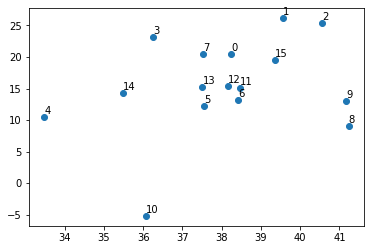

In [6]:
plt.scatter(ulysses16[:, 0], ulysses16[:, 1])
for i in range(0, 16):
    plt.annotate(i, (ulysses16[i, 0], ulysses16[i, 1]+0.5))

## Naive Solution: In Order

In [7]:
simple_sequence = list(range(0, 16))
print(simple_sequence)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


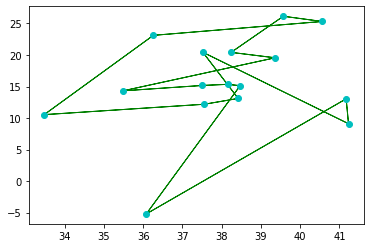

In [8]:
plotTSP([simple_sequence], ulysses16, num_iters=1)

## Naive Solution: Random Permutation

In [9]:
random_permutation = np.random.permutation(16).tolist()
print(random_permutation)

[1, 8, 9, 12, 3, 2, 6, 11, 0, 14, 15, 7, 4, 5, 13, 10]


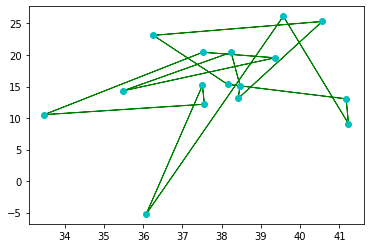

In [10]:
plotTSP([random_permutation], ulysses16, num_iters=1)

## Best Solution

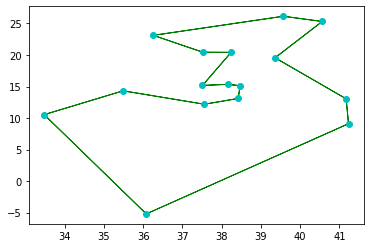

In [11]:
best_ulysses16 = [0, 13, 12, 11, 6, 5, 14, 4, 10, 8, 9, 15, 2, 1, 3, 7]
plotTSP([best_ulysses16], ulysses16, num_iters=1)

## Calculate Fitness (Sum of all Distances)

In [12]:
def dist(node_0, node_1, coords):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = coords[node_0], coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

In [13]:
print("Coordinate of City 0:", ulysses16[0])

Coordinate of City 0: [38.24 20.42]


In [14]:
print("Coordinate of City 1:", ulysses16[1])

Coordinate of City 1: [39.57 26.15]


In [15]:
print("Distance Between", dist(0, 1, ulysses16))

Distance Between 5.882329470541408


In [16]:
def fitness(solution, coords):
    N = len(coords)
    cur_fit = 0
    for i in range(len(solution)):
        cur_fit += dist(solution[i % N], solution[(i + 1) % N], coords)
    return cur_fit

In [17]:
print ("Order Fitness:\t", fitness(simple_sequence, ulysses16))
print ("Random Fitness:\t", fitness(random_permutation, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Order Fitness:	 104.42225210207233
Random Fitness:	 142.71833065004333
Best Fitness:	 74.10873595815309


## Naive Random Model

In [18]:
import math
import random
from model.base_model import Model

class MyRandomModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        random_solutions = []
        for i in range(0, max_it):
            solution = np.random.permutation(self.N).tolist()
            random_solutions.append(solution)
            self.fitness_list.append(self.fitness(solution))

        self.best_solution = random_solutions[self.fitness_list.index(min(self.fitness_list))]
        return self.best_solution, self.fitness_list

In [19]:
tsp_file = './template/data/simple/ulysses16.tsp'

In [20]:
model = MyRandomModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model, max_it=100)

[*] [Node] 16, [Best] 108.63032651658955
[*] Running for: 0.01 seconds



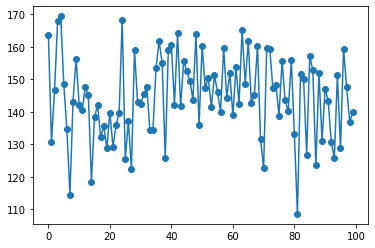

In [21]:
plt.plot(fitness_list, 'o-')

## Genetic Algorithm

In [244]:
class Gene:  # City
    def __init__(self, name, lat, lng):
        self.name = name
        self.lat = lat
        self.lng = lng

    def get_distance_to(self, dest):
        return math.sqrt( (self.lng - dest.lng) ** 2 + (self.lat - dest.lat) ** 2 )

class Individual:  # Route: possible solution to TSP
    def __init__(self, genes):
        assert(len(genes) > 3)
        self.genes = genes
        self.__reset_params()

    def swap(self, gene_1, gene_2):
        self.genes[0]
        a, b = self.genes.index(gene_1), self.genes.index(gene_2)
        self.genes[b], self.genes[a] = self.genes[a], self.genes[b]
        self.__reset_params()

    def add(self, gene):
        self.genes.append(gene)
        self.__reset_params()

    @property
    def fitness(self):
        if self.__fitness == 0:
            self.__fitness = 1 / self.travel_cost  # Normalize travel cost
        return self.__fitness

    @property
    def travel_cost(self):  # Get total travelling cost
        if self.__travel_cost == 0:
            for i in range(len(self.genes)):
                origin = self.genes[i]
                if i == len(self.genes) - 1:
                    dest = self.genes[0]
                else:
                    dest = self.genes[i+1]

                self.__travel_cost += origin.get_distance_to(dest)

        return self.__travel_cost

    def __reset_params(self):
        self.__travel_cost = 0
        self.__fitness = 0

class Population:  # Population of individuals
    def __init__(self, individuals):
        self.individuals = individuals

    @staticmethod
    def gen_individuals(sz, genes):
        individuals = []
        for _ in range(sz):
            individuals.append(Individual(sample(genes, len(genes))))
        return Population(individuals)

    def add(self, route):
        self.individuals.append(route)

    def rmv(self, route):
        self.individuals.remove(route)

    def get_fittest(self):
        fittest = self.individuals[0]
        for route in self.individuals:
            if route.fitness > fittest.fitness:
                fittest = route

        return fittest

In [380]:
import math
import random
from model.base_model import Model
from random import randint, sample

class MyGAModel(Model):
    def __init__(self):
        super().__init__()
        self.iteration = 0

    def init(self, nodes):
        super().init(nodes)

    def evolve(self, pop, tourn_size, mut_rate):
        new_generation = Population([])
        pop_size = len(pop.individuals)
        elitism_num = pop_size // 4

        # Elitism
        for _ in range(elitism_num):
            fittest = pop.get_fittest()
            new_generation.add(fittest)
            pop.rmv(fittest)

        # Crossover
        for _ in range(elitism_num, pop_size):
            parent_1 = self.selection(new_generation, tourn_size)
            parent_2 = self.selection(new_generation, tourn_size)
            child = self.crossover(parent_1, parent_2)
            new_generation.add(child)

        # Mutation
        for i in range(elitism_num, pop_size):
            self.mutate(new_generation.individuals[i], mut_rate)

        return new_generation

    def crossover(self, parent_1, parent_2):
        def fill_with_parent1_genes(child, parent, genes_n):
            start_at = randint(0, len(parent.genes)-genes_n-1)
            finish_at = start_at + genes_n
            for i in range(start_at, finish_at):
                child.genes[i] = parent_1.genes[i]

        def fill_with_parent2_genes(child, parent):
            j = 0
            for i in range(0, len(parent.genes)):
                if child.genes[i] == None:
                    while parent.genes[j] in child.genes:
                        j += 1
                    child.genes[i] = parent.genes[j]
                    j += 1

        genes_n = len(parent_1.genes)
        child = Individual([None for _ in range(genes_n)])
        fill_with_parent1_genes(child, parent_1, genes_n // 2)
        fill_with_parent2_genes(child, parent_2)

        return child

    def mutate(self, individual, rate):
        for _ in range(len(individual.genes)):
            if random.random() < rate:
                sel_genes = sample(individual.genes, 2)
                individual.swap(sel_genes[0], sel_genes[1])

    def selection(self, population, competitors_n):
        return Population(sample(population.individuals, competitors_n)).get_fittest()

    def fit(self, max_it=20):
        """
        Execute simulated annealing algorithm.
        """
        pop_size = 1000
        mut_rate = 0.9
        tourn_size = 100

        genes = [Gene(num, city[0], city[1]) for num, city in enumerate(self.coords)]
        self.genes = genes

        population = Population.gen_individuals(pop_size, genes)
        

        for it in range(0, max_it):
            mut_rate = mut_rate * 0.95
            if mut_rate < 0.05:
                mut_rate = 0.05
            population = self.evolve(population, tourn_size, mut_rate)
            cost = population.get_fittest().travel_cost

            it += 1
            self.fitness_list.append(cost)
            print("[step] ", it, " [mut] ", mut_rate, " [best] ", self.fitness_list[self.fitness_list.index(min(self.fitness_list))])

        self.best_solution = [gene.name for gene in population.get_fittest().genes]

        return self.best_solution, self.fitness_list

In [381]:
tsp_problem = "./template/data/simple/ulysses16.tsp"

In [382]:
model = MyGAModel()

print("Genetic Algorithm")
best_solution, fitness_list, time = TSP_Bench(tsp_problem, model, max_it=200)

Genetic Algorithm
[step]  1  [mut]  0.855  [best]  96.11229392543888
[step]  2  [mut]  0.8122499999999999  [best]  93.76996122899693
[step]  3  [mut]  0.7716374999999999  [best]  93.76996122899693
[step]  4  [mut]  0.7330556249999999  [best]  93.36477102051143
[step]  5  [mut]  0.6964028437499998  [best]  93.36477102051143
[step]  6  [mut]  0.6615827015624998  [best]  93.36477102051143
[step]  7  [mut]  0.6285035664843748  [best]  90.01149831972343
[step]  8  [mut]  0.597078388160156  [best]  90.01149831972343
[step]  9  [mut]  0.5672244687521482  [best]  89.10668237027161
[step]  10  [mut]  0.5388632453145408  [best]  89.10668237027161
[step]  11  [mut]  0.5119200830488138  [best]  89.10668237027161
[step]  12  [mut]  0.486324078896373  [best]  75.20103046245312
[step]  13  [mut]  0.4620078749515544  [best]  75.20103046245312
[step]  14  [mut]  0.43890748120397666  [best]  75.20103046245312
[step]  15  [mut]  0.4169621071437778  [best]  75.10440611823527
[step]  16  [mut]  0.396114001

[step]  151  [mut]  0.05  [best]  73.987618045175
[step]  152  [mut]  0.05  [best]  73.987618045175
[step]  153  [mut]  0.05  [best]  73.987618045175
[step]  154  [mut]  0.05  [best]  73.987618045175
[step]  155  [mut]  0.05  [best]  73.987618045175
[step]  156  [mut]  0.05  [best]  73.987618045175
[step]  157  [mut]  0.05  [best]  73.987618045175
[step]  158  [mut]  0.05  [best]  73.987618045175
[step]  159  [mut]  0.05  [best]  73.987618045175
[step]  160  [mut]  0.05  [best]  73.987618045175
[step]  161  [mut]  0.05  [best]  73.987618045175
[step]  162  [mut]  0.05  [best]  73.987618045175
[step]  163  [mut]  0.05  [best]  73.987618045175
[step]  164  [mut]  0.05  [best]  73.987618045175
[step]  165  [mut]  0.05  [best]  73.987618045175
[step]  166  [mut]  0.05  [best]  73.987618045175
[step]  167  [mut]  0.05  [best]  73.987618045175
[step]  168  [mut]  0.05  [best]  73.987618045175
[step]  169  [mut]  0.05  [best]  73.987618045175
[step]  170  [mut]  0.05  [best]  73.987618045175


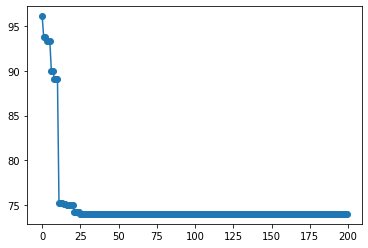

In [383]:
plt.plot(fitness_list, 'o-')

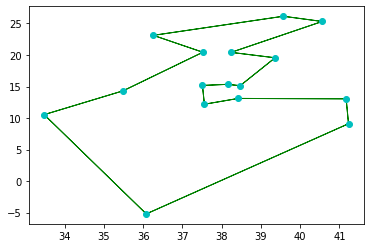

In [384]:
plotTSP([best_solution], load_data(tsp_problem), num_iters=1)

In [386]:
print ("Best Fitness:\t", fitness(best_solution, ulysses16))
print ("Best Fitness:\t", fitness(best_ulysses16, ulysses16))

Best Fitness:	 73.987618045175
Best Fitness:	 74.10873595815309


## Your Smart Model

In [72]:
import math
import random
from model.base_model import Model

class MyModel(Model):
    def __init__(self):
        super().__init__()

    def init(self, nodes):
        """
        Put your initialization here.
        """
        super().init(nodes)
        self.log("Nothing to initialize in your model now")

    def fit(self, max_it):
        """
        Put your iteration process here.
        """
        self.log("Naive Random Solution")
        self.best_solution = np.random.permutation(self.N).tolist()
        self.fitness_list.append(self.fitness(self.best_solution))

        return self.best_solution, self.fitness_list

## Test your Model

In [73]:
tsp_problem = './template/data/simple/ulysses16.tsp'

In [74]:
model = MyModel()
best_solution, fitness_list, time = TSP_Bench(tsp_file, model)

[MyModel] Nothing to initialize in your model now
[MyModel] Naive Random Solution
[*] [Node] 16, [Best] 147.19356281214667
[*] Running for: 0.01 seconds



# Test All Dataset

In [90]:
for root, _, files in os.walk('./template/data'):
    if(files):
        for f in files:
            print(str(root) + "/" + f)

./template/data/medium/pcb442.tsp
./template/data/medium/a280.tsp
./template/data/hard/dsj1000.tsp
./template/data/simple/att48.tsp
./template/data/simple/ulysses16.tsp
./template/data/simple/st70.tsp


In [91]:
def plot_results(best_solutions, times, title):
    fig = plt.figure()
    nodes = [len(s) for s in best_solutions]
    data = np.array([[node, time] for node, time in sorted(zip(nodes, times))])
    plt.plot(data[:, 0], data[:, 1], 'o-')
    fig.suptitle(title, fontsize=20)

In [94]:
tsp_path = './template/data/medium'

In [95]:
model = MyRandomModel()

print("Random Search")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model)

Random Search
[*] ./template/data/medium/pcb442.tsp
[*] [Node] 442, [Best] 722875.708265324
[*] Running for: 0.26 seconds

[*] ./template/data/medium/a280.tsp
[*] [Node] 280, [Best] 31126.512432333657
[*] Running for: 0.16 seconds



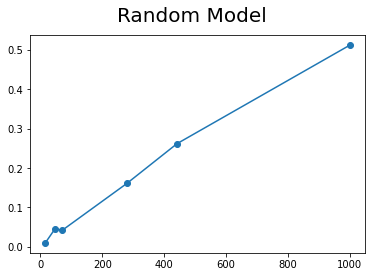

In [79]:
plot_results(best_solutions, times, "Random Model")

In [82]:
model = MyGAModel()

print("Genetic Algorithm")
best_solutions, fitness_lists, times = TSP_Bench_ALL(tsp_path, model, max_it=100, timeout=600)

Genetic Algorithm
[*] ./template/data/medium/pcb442.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.12 seconds

[*] ./template/data/medium/a280.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.05 seconds

[*] ./template/data/hard/dsj1000.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.38 seconds

[*] ./template/data/simple/att48.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.01 seconds

[*] ./template/data/simple/ulysses16.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.00 seconds

[*] ./template/data/simple/st70.tsp
'module' object is not callable
[*] Unkown -4
[*] No Answer -1
[*] Running for: 0.01 seconds



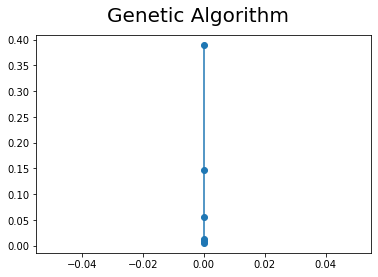

In [81]:
plot_results(best_solutions, times, "Genetic Algorithm")